In [577]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Kaggle Workshops Starter Notebook [Python version]
## Online Retail Store: Predicting Visitor Behaviour 

<table align="left">
  <td>
    <a href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Online%20Retail%20Store%3A%20Predicting%20Visitor%20Behaviour%20-%20Starter%20Notebook%20%5BPython%5D&download_url=https%3A%2F%2Fstorage.googleapis.com%2Fstarter_notebooks%2Fgoogle_analytics_sample_bqml_python.ipynb&url=https%3A%2F%2Fgist.github.com%2Fpolong-lin%2F51bb01bac82513294e10fb9856c4fdb0">
      <img src="https://cloud.google.com/images/products/ai/ai-solutions-icon.svg" alt="AI Platform Notebooks">Run on AI Platform Notebooks</a>
  </td>
</table>

- [Setup BigQuery in Jupyter](#setup)
- [BigQuery ML basics](#basics)
  - [Select BigQuery data from Python](#select)
  - [Train a BigQuery ML model](#train)
  - [Check models currently being trained on BigQuery](#currentlytraining)
  - [Check if a model has finished training](#finishedtraining)
  - [Evaluate a BigQuery ML model](#evaluate)
  - [Compare multiple models](#compare)
  - [ML.FEATURE_INFO to check input feature information](#featinfo)
  - [Make predictions using BigQuery ML](#predictions)
  - [Export predictions as a CSV file](#exportcsv)
- [Feature engineering](#feateng)
  - [EXTRACT: Extract dates and time](#extractdates)
  - [REGEXP_EXTRACT_ALL: Extract words from a STRING column](#extractwords)
  - [ML.QUANTILE_BUCKETIZE: Bucketize your numeric feature into bins](#bucketize)
  - [ML.POLYNOMIAL_EXPAND: Combine numeric features](#polynomialexpand)
  - [ML.FEATURE_CROSS: Combine categorical features](#featurecross)
- [Feature selection](#featselection)
  - [ML.FEATURE_IMPORTANCE for Boosted Tree models](#featimportance)

<a id="setup"></a>

### Setup BigQuery in Jupyter 

#### Set parameters

In [727]:
#Check current GCP project ID
!gcloud config get-value project

globohack-kaggle21-6924


In [728]:
PROJECT_ID = "globohack-kaggle21-6924" #REPLACE with project ID
DATASET_ID = "bqmlretail"
LOCATION = "EU"

#### Create dataset if it does not yet exist

In [731]:
!bq mk --location=$LOCATION $DATASET_ID

BigQuery error in mk operation: Dataset 'globohack-kaggle21-6924:bqmlretail'
already exists.


#### Required libraries

In [581]:
#!pip install google-cloud-bigquery --upgrade --quiet

In [961]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from google.cloud import bigquery
from google.api_core.exceptions import BadRequest
import time
import pandas as pd
import numpy as np
from sklearn import preprocessing, tree
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# Construct a BigQuery client object.
client = bigquery.Client()

def bq_query(sql, async_flag=False):
    """
    If `async_flag` set to False (default), 
        returns the query results for `sql` as a Pandas DataFrame, 
    Else, submits query asynchronously and returns nothing.
    """
    
    # Try dry run before executing query to catch any errors
    try:
        job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
        dry_run_job = client.query(sql, job_config=job_config)
    except BadRequest as err:
        print(err)
        return
        
    job_config = bigquery.QueryJobConfig()
    df = client.query(sql, job_config=job_config)
    
    if async_flag:
        return f"Query sent asynchronously for job id: {df.job_id}"
    else:
        df = df.result() #wait for query to finish running
        return df.to_dataframe()
    

def pandas_to_bq(df, tablename):
    return client.load_table_from_dataframe(
        dataframe = df, 
        destination = DATASET_ID + '.' + tablename,
        project = PROJECT_ID
    )
    
print("Done.")

Done.


<a id="basics"></a>

## BigQuery ML basics

<a id="select"></a>

#### Select BigQuery data from Python

In [962]:
#t.* EXCEPT (totalHits, totalVisits, date, isMobile, browser, city, trafficSource, trafficMedium, trafficCampaign, operatingSystem), 

sql_select = """
WITH
train AS (
    (SELECT 
      *,
      NET.REG_DOMAIN(trafficSource) AS domainSource,
      CAST(isMobile AS INT64) AS isMobile,
      EXTRACT(DAYOFWEEK FROM TIMESTAMP_MILLIS(visitStartTime*1000)) AS dayOfWeek,
      IF (EXTRACT(DAYOFWEEK FROM TIMESTAMP_MILLIS(visitStartTime*1000)) IN (1,7), 1, 0) AS isWeekend,
      IF (operatingSystem IN ('Macintosh', 'iOS'), 1, 0) AS isApple,
      LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC) AS lastVisitTime,
      CASE
        WHEN TIMESTAMP_DIFF(TIMESTAMP_MILLIS(visitStartTime), TIMESTAMP_MILLIS(LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC)), HOUR) <= 24 THEN 1
        ELSE 0
      END AS hasRecentVisit,
      CASE
        WHEN totalTimeOnSite = 0 THEN 1
        ELSE 0
      END AS noTimeOnSite
    FROM
      kaggleworkshops.google_analytics_sample_eu.train t
    WHERE date BETWEEN TIMESTAMP("2010-01-01")
      AND TIMESTAMP("2021-12-31")
      AND addedToCart=1)
    UNION ALL(
        SELECT 
          *,
          NET.REG_DOMAIN(trafficSource) AS domainSource,
          CAST(isMobile AS INT64) AS isMobile,
          EXTRACT(DAYOFWEEK FROM TIMESTAMP_MILLIS(visitStartTime*1000)) AS dayOfWeek,
          IF (EXTRACT(DAYOFWEEK FROM TIMESTAMP_MILLIS(visitStartTime*1000)) IN (1,7), 1, 0) AS isWeekend,
          IF (operatingSystem IN ('Macintosh', 'iOS'), 1, 0) AS isApple,
          LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC) AS lastVisitTime,
          CASE
            WHEN TIMESTAMP_DIFF(TIMESTAMP_MILLIS(visitStartTime), TIMESTAMP_MILLIS(LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC)), HOUR) <= 24 THEN 1
            ELSE 0
          END AS hasRecentVisit,
          CASE
            WHEN totalTimeOnSite = 0 THEN 1
            ELSE 0
          END AS noTimeOnSite
        FROM
          kaggleworkshops.google_analytics_sample_eu.train t
        WHERE date BETWEEN TIMESTAMP("2016-01-01")
          AND TIMESTAMP("2016-12-31")
          AND addedToCart=0
          LIMIT 50000
    )
)
SELECT * EXCEPT (visitStartTime, lastVisitTime)
FROM train
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(visitStartTime AS STRING))), 100) <= 60
"""

df = bq_query(sql = sql_select) #.set_index('fullVisitorId')

df.tail()

,fullVisitorId,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,isFirstVisit,totalVisits,totalHits,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart,domainSource,isMobile_1,dayOfWeek,isWeekend,isApple,hasRecentVisit,noTimeOnSite
55905,2099874963563697649,2016-12-18 00:00:00+00:00,desktop,False,Macintosh,Chrome,Spain,Madrid,Partners,affiliate,Data Share Promo,1,1,1,1,0,0,0,None,0,1,1,1,0,1
55906,2103516610461663217,2016-08-04 00:00:00+00:00,desktop,False,Windows,Chrome,United States,Los Angeles,google,organic,(not set),1,1,5,5,104,0,0,None,0,5,0,0,0,0
55907,2103516610461663217,2016-08-19 00:00:00+00:00,desktop,False,Windows,Chrome,United States,Los Angeles,google,organic,(not set),0,1,8,6,105,2,0,None,0,6,0,0,1,0
55908,2103516610461663217,2016-08-22 00:00:00+00:00,desktop,False,Windows,Chrome,United States,Los Angeles,google,organic,(not set),0,1,3,3,52,0,0,None,0,2,0,0,1,0
55909,210763430517443415,2016-12-14 00:00:00+00:00,desktop,False,Linux,Chrome,Israel,Tel Aviv-Yafo,(direct),(none),(not set),1,1,3,3,56,0,0,None,0,4,0,0,0,0


In [963]:
df['noTimeOnSite'].value_counts()

0    39843
1    16067
Name: noTimeOnSite, dtype: int64

In [964]:
df['addedToCart'].value_counts()

0    30549
1    25361
Name: addedToCart, dtype: int64

In [965]:
df.shape

(55910, 25)

# Mini EDA

In [966]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55910 entries, 0 to 55909
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   fullVisitorId       55910 non-null  object             
 1   date                55910 non-null  datetime64[ns, UTC]
 2   deviceCategory      55910 non-null  object             
 3   isMobile            55910 non-null  bool               
 4   operatingSystem     55910 non-null  object             
 5   browser             55910 non-null  object             
 6   country             55910 non-null  object             
 7   city                55910 non-null  object             
 8   trafficSource       55910 non-null  object             
 9   trafficMedium       55910 non-null  object             
 10  trafficCampaign     55910 non-null  object             
 11  isFirstVisit        55910 non-null  int64              
 12  totalVisits         55910 non-nu

## Plot functions

In [585]:
def plot_integer_to_label(df, feature):
    g = sns.factorplot(x=feature, y="addedToCart", data=df, kind="bar", size=4, palette = "muted")
    g.despine(left=True)
    g = g.set_ylabels("addedToCart")
    print(df[[feature, 'addedToCart']].groupby([feature]).agg(['mean', 'count']))

In [586]:
def plot_float_to_label(df, feature):
    g = sns.distplot(df[feature], color="m", label="Skewness : %.2f"%(df[feature].skew()))
    g = g.legend(loc="best")
    
    g = sns.FacetGrid(df, col='addedToCart')
    g = g.map(sns.distplot, feature)

In [649]:
def plot_categorical_variable_2(column: str, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    df_plot = pd.DataFrame(df.groupby(column)['fullVisitorId'].count()).reset_index(drop=False)
    sns.barplot(data=df_plot, x="fullVisitorId", y=column, ax=ax)

In [650]:
def plot_categorical_variable(df, column_x, column_y, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=df, x=column_x, y=column_y, ax=ax)

In [588]:
def plot_numerical_variable(column:str, figsize=(16,8), log=False, max_value=None):
    fig, ax = plt.subplots(figsize=figsize)
    df_plot = df.copy()
    if max_value:
        df_plot = df_plot.query(f'{column} <= {max_value}')
    
    if log:
        sns.distplot(np.log(1+df_plot[column]), ax=ax)
    else:
        sns.distplot(df_plot[column], ax=ax)

In [589]:
def to_integer(data, feature):
    le = preprocessing.LabelEncoder()
    le.fit(data[feature])
    data[feature] = le.transform(data[feature])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


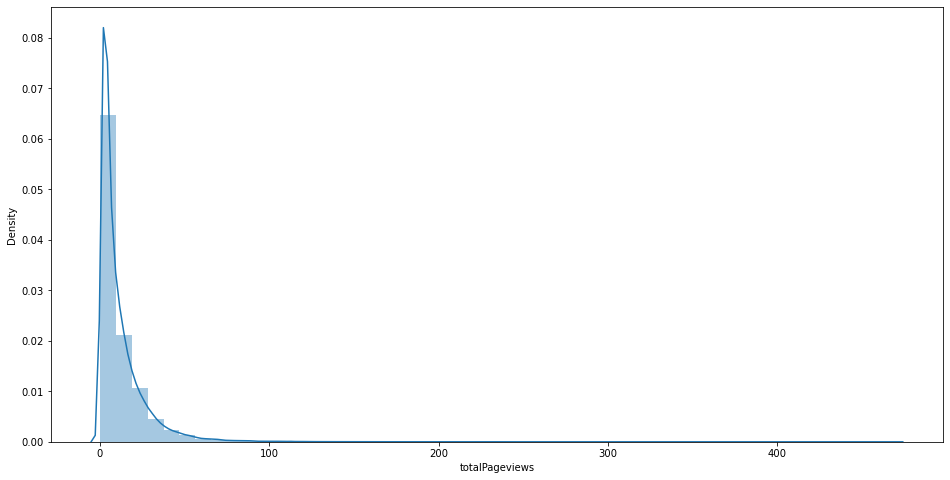

In [673]:
plot_numerical_variable('totalPageviews', log=False, max_value = None)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

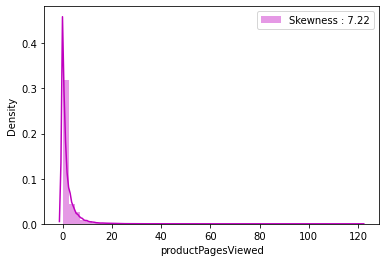

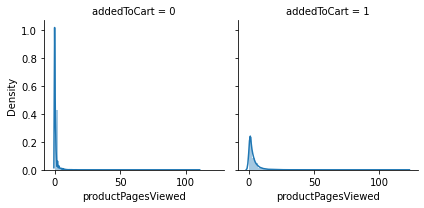

In [674]:
plot_float_to_label(df, 'productPagesViewed')

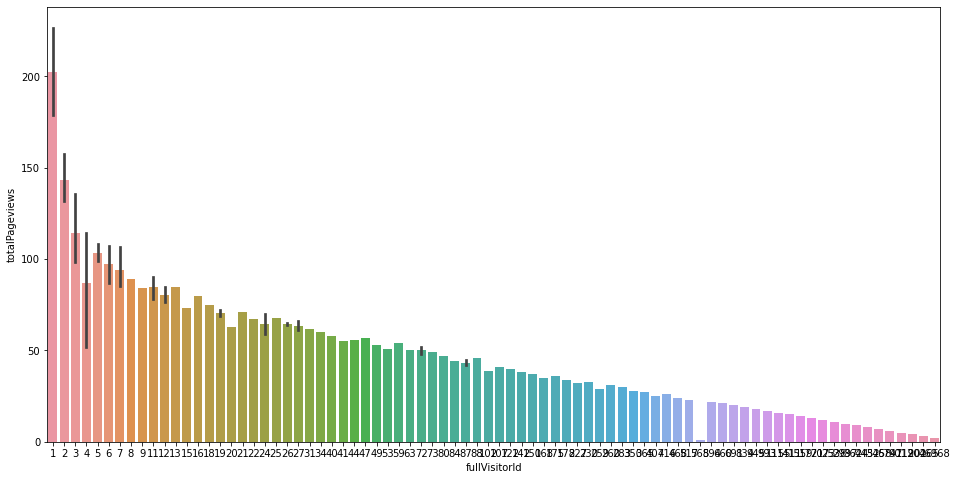

In [592]:
plot_categorical_variable('totalPageviews')

## Inspecting features

In [675]:
for column in df.columns:
    values_count = len(df[column].unique())
    if values_count >= 5:
        print("Colum: {} has mora than 5 values".format(column))
    else:# values_count < 5:
        print("\nColum: {}".format(column))
        print(df[column].value_counts())
        print("\n")

Colum: fullVisitorId has mora than 5 values
Colum: date has mora than 5 values

Colum: deviceCategory
desktop    44937
mobile      9508
tablet      1550
Name: deviceCategory, dtype: int64



Colum: isMobile
False    44938
True     11057
Name: isMobile, dtype: int64


Colum: operatingSystem has mora than 5 values
Colum: browser has mora than 5 values
Colum: country has mora than 5 values
Colum: city has mora than 5 values
Colum: trafficSource has mora than 5 values
Colum: trafficMedium has mora than 5 values
Colum: trafficCampaign has mora than 5 values

Colum: isFirstVisit
1    38749
0    17246
Name: isFirstVisit, dtype: int64



Colum: totalVisits
1    55995
Name: totalVisits, dtype: int64


Colum: totalHits has mora than 5 values
Colum: totalPageviews has mora than 5 values
Colum: totalTimeOnSite has mora than 5 values
Colum: productPagesViewed has mora than 5 values

Colum: addedToCart
0    30641
1    25354
Name: addedToCart, dtype: int64


Colum: domainSource has mora than 5 values

In [676]:
df.describe()

,isFirstVisit,totalVisits,totalHits,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart,isMobile_1,dayOfWeek,isWeekend,isApple,hasRecentVisit
count,55995.000000,55995.0,55995.000000,55995.000000,55995.000000,55995.000000,55995.000000,55995.000000,55995.000000,55995.000000,55995.000000,55995.000000
mean,0.692008,1.0,15.636164,11.877257,434.476525,1.852737,0.452790,0.197464,4.008715,0.197553,0.474507,0.177141
std,0.461667,0.0,21.780946,15.544879,693.222734,3.830399,0.497771,0.398089,1.825317,0.398157,0.499354,0.381791
min,0.000000,1.0,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.0,3.000000,3.000000,52.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,1.000000,1.0,8.000000,7.000000,163.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000
75%,1.000000,1.0,20.000000,15.000000,528.000000,2.000000,1.000000,0.000000,6.000000,0.000000,1.000000,0.000000
max,1.000000,1.0,500.000000,469.000000,19017.000000,121.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000


In [677]:
df['deviceCategory'].value_counts()

desktop    44937
mobile      9508
tablet      1550
Name: deviceCategory, dtype: int64

In [678]:
df['country'].value_counts()

United States       31461
India                2341
Canada               2183
Vietnam              1409
United Kingdom       1347
                    ...  
Ethiopia                1
Dominica                1
Papua New Guinea        1
Grenada                 1
Gabon                   1
Name: country, Length: 174, dtype: int64

In [679]:
df['trafficCampaign'].value_counts()

(not set)                             54260
Data Share Promo                        975
AW - Dynamic Search Ads Whole Site      558
AW - Accessories                        188
AW - Electronics                         13
AW - Apparel                              1
Name: trafficCampaign, dtype: int64

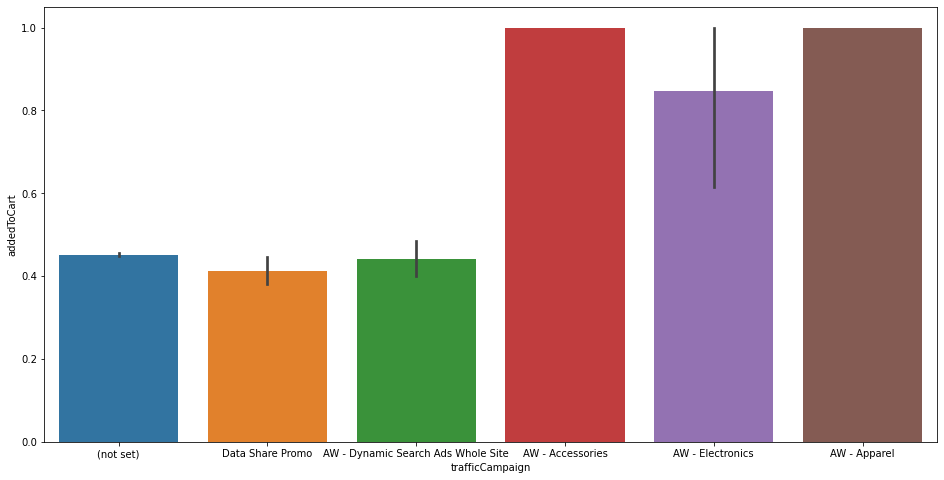

In [680]:
plot_categorical_variable(df, 'trafficCampaign', 'addedToCart') #'domainSourceFiltered')

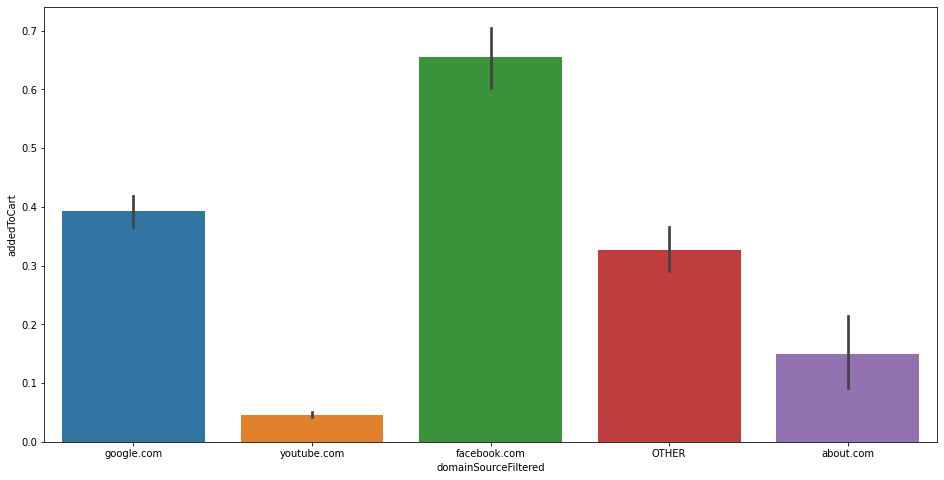

In [705]:
plot_categorical_variable(df, 'domainSourceFiltered', 'addedToCart') #'domainSourceFiltered')

## Preprocessing

In [681]:
@np.vectorize
def binarize_time_on_site(time, threshold=5):
    return 1 if time > 5 else 0

@np.vectorize
def binarize_product_pages_viewed(pv):
    if pv <= 1:
        return 1
    elif pv > 1 and pv <= 3:
        return 2
    elif pv > 3:
        return 5
    return 0


@np.vectorize
def get_continent_code(country): 
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")

        return pc.country_alpha2_to_continent_code(country_code)
    except:
        return 'Other'

In [967]:
domain_value_counts = df['domainSource'].value_counts()
invalid_domains = list(domain_value_counts[domain_value_counts < 100].index)
df['domainSourceFiltered'] = df['domainSource'].apply(lambda x : "OTHER" if x in invalid_domains else x)

In [968]:
def get_relation(data: pd.DataFrame(), col: str):
    relation_df = pd.DataFrame(data\
        .groupby(by=[col, 'addedToCart'])\
        .count()['fullVisitorId']).reset_index()\
        .pivot(index=col, columns='addedToCart', values='fullVisitorId')
    relation_df['percent'] = relation_df[1] / (relation_df[0]+relation_df[1])
    return relation_df

In [684]:
get_relation(df, 'trafficMedium')

addedToCart,0,1,percent
trafficMedium,,,
(none),14650.0,15843.0,0.519562
(not set),NaN,2.0,NaN
affiliate,573.0,402.0,0.412308
cpc,336.0,476.0,0.586207
cpm,251.0,263.0,0.511673
organic,4709.0,6775.0,0.589951
referral,10122.0,1593.0,0.135980


## Removing Outliers

In [685]:
class TukeyOutlierRemover(BaseEstimator, TransformerMixin):

    __outliers = []
    __outliers_per_feature = {}

    def __init__(self, features):
        self.features = features

    def transform(self, X):
        return X.drop(self.__outliers, axis=0)

    def fit(self, X, y=None):
        outliers = []
        for col in self.features:
            feature_outliers = []
            feature_outliers.extend(X[X[col].isna()].index)
            Q1 = np.percentile(X[col].dropna(), 25)
            Q3 = np.percentile(X[col].dropna(), 75)
            IQR = Q3 - Q1
            outlier_step = 1.5 * IQR
            feature_outliers.extend(X[(X[col] < Q1 - outlier_step) | (X[col] > Q3 + outlier_step)].index)
            outliers.extend(feature_outliers)
            self.__outliers_per_feature[col] = feature_outliers
        self.__outliers = list(key for key, value in Counter(outliers).items())
        return self

    def get_outliers(self):
        return self.__outliers

    def get_outliers_per_feature(self, feature=None):
        if feature is not None:
            return self.__outliers_per_feature[feature]
        else:
            return self.__outliers_per_feature

In [969]:
columns_with_outliers = ["productPagesViewed", "totalPageviews"]

In [970]:
outlierRemover = TukeyOutlierRemover(columns_with_outliers)
df = outlierRemover.fit_transform(df)
print(len(outlierRemover.get_outliers()))

5752


In [971]:
len(df)

50158

In [972]:
valid_columns = ['hasRecentVisit', 'addedToCart', 'dayOfWeek', 'isWeekend', 'domainSourceFiltered', 'deviceCategory', 'isMobile', 'trafficMedium', 'trafficCampaign', 'isFirstVisit', 'totalPageviews', 'productPagesViewed']
df[valid_columns].head()

,hasRecentVisit,addedToCart,dayOfWeek,isWeekend,domainSourceFiltered,deviceCategory,isMobile,trafficMedium,trafficCampaign,isFirstVisit,totalPageviews,productPagesViewed
0,0,1,2,0,None,desktop,False,organic,(not set),1,23,1
1,0,1,4,0,None,mobile,True,cpc,AW - Accessories,1,17,1
2,0,1,6,0,None,desktop,False,(none),(not set),1,9,0
3,0,1,2,0,None,desktop,False,(none),(not set),1,19,1
5,0,1,5,0,None,desktop,False,organic,(not set),1,9,1


In [690]:
valid_columns

['addedToCart',
 'dayOfWeek',
 'isWeekend',
 'domainSourceFiltered',
 'deviceCategory',
 'isMobile',
 'trafficMedium',
 'trafficCampaign',
 'isFirstVisit',
 'totalPageviews',
 'productPagesViewed']

In [861]:
for column in valid_columns:
    print("Colum: {} ".format(column))
    print(df[column].isna().sum())

Colum: hasRecentVisit 
0
Colum: addedToCart 
0
Colum: dayOfWeek 
0
Colum: isWeekend 
0
Colum: domainSourceFiltered 
38502
Colum: deviceCategory 
0
Colum: isMobile 
0
Colum: trafficMedium 
0
Colum: trafficCampaign 
0
Colum: isFirstVisit 
0
Colum: totalPageviews 
0
Colum: productPagesViewed 
0


## Correlation Matrix

In [692]:
def print_PCF(df):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [693]:
def to_integer(df, feature):
    le = preprocessing.LabelEncoder()
    le.fit(df[feature])
    df[feature] = le.transform(df[feature])
    return df

In [973]:
df['is_facebook'] = (df['domainSourceFiltered']=='facebook.com').astype(int)
df['is_youtube'] = (df['domainSourceFiltered']=='youtube.com').astype(int)

In [888]:
df_with_ints = df.copy()
for column in ['domainSourceFiltered', 'deviceCategory', 'trafficMedium', 'trafficCampaign']:
    to_integer(df_with_ints, column)

In [889]:
df.shape

(49923, 27)

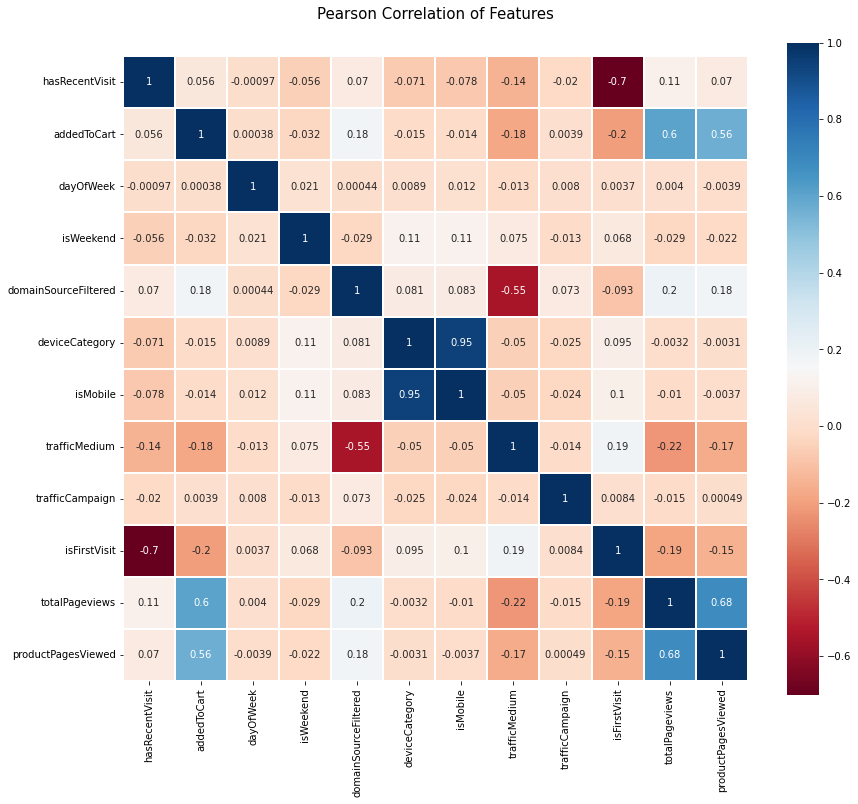

In [890]:
print_PCF(df_with_ints[valid_columns])

In [928]:
most_correlated_features = ['addedToCart', 'trafficMedium', 'isFirstVisit', 'totalPageviews']
most_correlated_features_2 = ['addedToCart', 'trafficMedium', 'isFirstVisit', 'totalPageviews', 'productPagesViewed']
valid_columns = ['addedToCart', 'isWeekend', 'domainSourceFiltered', 'deviceCategory', 'isMobile', 'trafficMedium', 'trafficCampaign', 'isFirstVisit', 'totalPageviews', 'productPagesViewed']
all_features_except_pv = ['addedToCart', 'isWeekend', 'domainSourceFiltered', 'deviceCategory', 'isMobile', 'trafficMedium', 'trafficCampaign', 'isFirstVisit', 'totalPageviews']

In [974]:
winner_columns = ['noTimeOnSite', 'addedToCart', 'trafficMedium', 'isFirstVisit', 'totalPageviews', 'productPagesViewed', 'is_facebook', 'is_youtube'] 

In [952]:
df['noTimeOnSite'].value_counts()

0    49942
Name: noTimeOnSite, dtype: int64

In [953]:
len(df)

49942

## Save temp tables to BQ

In [754]:
TABLE_NAME = "train_processed_v1"
pandas_to_bq(df[most_correlated_features].reset_index(drop=True), TABLE_NAME)

LoadJob<project=globohack-kaggle21-6924, location=EU, id=129926bc-4103-46d2-b2d1-80ca7990649a>

In [830]:
TABLE_NAME = "train_processed_v21"
pandas_to_bq(df[most_correlated_features_2].reset_index(drop=True), TABLE_NAME)

LoadJob<project=globohack-kaggle21-6924, location=EU, id=4befb28c-0ff3-46a1-9f9f-9e2158bccde9>

In [756]:
TABLE_NAME = "train_processed_v3"
pandas_to_bq(df[all_features_except_pv].reset_index(drop=True), TABLE_NAME)

LoadJob<project=globohack-kaggle21-6924, location=EU, id=f6d71ad7-399b-471d-a758-f66536116445>

In [894]:
TABLE_NAME = "train_processed_v22"
pandas_to_bq(df[winner_columns].reset_index(drop=True), TABLE_NAME)

LoadJob<project=globohack-kaggle21-6924, location=EU, id=a405a9de-e895-4f1e-bec1-eba1665b8995>

In [976]:
TABLE_NAME = "train_processed_v4"
pandas_to_bq(df[winner_columns].reset_index(drop=True), TABLE_NAME)

LoadJob<project=globohack-kaggle21-6924, location=EU, id=22a45b17-acb5-40e4-8934-dc4c2ccd1ff9>

# Train

<a id="train"></a>

#### Train a BigQuery ML model: benchmark

In [14]:
sql_logreg_sample = """
CREATE OR REPLACE MODEL bqmlretail.logreg_sample
TRANSFORM(
  LOWER(country) country_lower,
  totalPageviews,
  addedToCart
)
OPTIONS(
  model_type='logistic_reg', 
  INPUT_LABEL_COLS=["addedToCart"]) AS
SELECT 
  *
FROM
  kaggleworkshops.google_analytics_sample_eu.train
WHERE date BETWEEN TIMESTAMP("2016-08-01")
  AND TIMESTAMP("2016-08-31")
"""

#send asynchronously
bq_query(sql = sql_logreg_sample,
        async_flag=True)

'Query sent asynchronously for job id: 3b73beb1-65ef-4654-9ec5-c9f6531024c2'

### 1. Logistic regression with hyperparam tunning

In [977]:
TABLE_NAME = "train_processed_v4"
model_name = 'logistic_reg_v4'

sql_logreg_sample = f"""
CREATE OR REPLACE MODEL bqmlretail.{model_name}
TRANSFORM("""

sql_logreg_sample += ', '.join(df[winner_columns].columns)
  
sql_logreg_sample += f"""
)
OPTIONS(
  model_type='logistic_reg', 
  INPUT_LABEL_COLS=["addedToCart"],
  num_trials=10,
  HPARAM_TUNING_ALGORITHM = 'VIZIER_DEFAULT',
  HPARAM_TUNING_OBJECTIVES = ['ROC_AUC'],
  DATA_SPLIT_METHOD = 'RANDOM', 
  l1_reg = HPARAM_RANGE(0, 10),
  l2_reg = HPARAM_RANGE(0, 10)
) AS
SELECT 
  *
FROM
  `{PROJECT_ID}.{DATASET_ID}.{TABLE_NAME}`
"""

#send asynchronously
bq_query(sql = sql_logreg_sample, async_flag=True)

'Query sent asynchronously for job id: 0eede3af-9ce4-4c2b-bbcf-e768137a7c2f'

### 2. Boosted Tree Classifier

In [988]:
TABLE_NAME = "train_processed_v4"

In [1022]:
model_name = 'boosted_tree_classifier_v7'

sql_tree_classifier = f"""
CREATE OR REPLACE MODEL bqmlretail.{model_name}
TRANSFORM("""

sql_tree_classifier += ', '.join(df[winner_columns].columns)
  
sql_tree_classifier += f"""
)
OPTIONS(
  model_type='boosted_tree_classifier', 
  INPUT_LABEL_COLS=["addedToCart"],
  num_trials=5,
  HPARAM_TUNING_ALGORITHM = 'VIZIER_DEFAULT',
  HPARAM_TUNING_OBJECTIVES = ['ROC_AUC'],
  DATA_SPLIT_METHOD = 'RANDOM', 
  l2_reg = HPARAM_RANGE(0, 10),
  max_tree_depth = HPARAM_RANGE(1, 5),
  num_parallel_tree=1
) AS
SELECT 
  *
FROM
  `{PROJECT_ID}.{DATASET_ID}.{TABLE_NAME}`
"""

#send asynchronously
bq_query(sql = sql_tree_classifier, async_flag=True)

'Query sent asynchronously for job id: 108b7de9-0634-428d-b2ad-b04621a98bac'

## DNN

In [1015]:
TABLE_NAME = "train_processed_v4"

In [1058]:
model_name = 'dnn_classifier_v2'

sql_dnn_classifier = f"""
CREATE OR REPLACE MODEL bqmlretail.{model_name}
TRANSFORM("""

sql_dnn_classifier += ', '.join(df[winner_columns].columns)
  
sql_dnn_classifier += f"""
)
OPTIONS(
  model_type='dnn_classifier', 
  INPUT_LABEL_COLS=["addedToCart"],
  num_trials=1,
  DATA_SPLIT_METHOD = 'RANDOM', 
  OPTIMIZER='SGD',
  ACTIVATION_FN='RELU',
  HPARAM_TUNING_ALGORITHM = 'VIZIER_DEFAULT',
  HPARAM_TUNING_OBJECTIVES = ['ROC_AUC'],
  l1_reg = HPARAM_RANGE(0, 10),
  HIDDEN_UNITS = HPARAM_RANGE(8, 16)
) AS
SELECT 
  *
FROM
  `{PROJECT_ID}.{DATASET_ID}.{TABLE_NAME}`
"""

#send asynchronously
bq_query(sql = sql_dnn_classifier, async_flag=True)

'Query sent asynchronously for job id: b5a58750-8e96-466a-aa40-979eed24146c'

Other model types for classification:
 - [`logistic_reg`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create)
 - [`boosted_tree_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree)
 - [`dnn_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models)
 - [`automl_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-automl)

<a id="currentlytraining"></a>

#### Check models currently being trained on BigQuery

This will check if the models in your project are still undergoing training.

In [1064]:
sql_currentlyrunningqueries = f"""
SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'{DATASET_ID}\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){{0,1}}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state != "DONE"
"""

print(sql_currentlyrunningqueries)

#send asynchronously
models_still_training = bq_query(sql_currentlyrunningqueries)

print(f"{len(models_still_training)} models still currently training:")
models_still_training


SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'bqmlretail\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){0,1}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state != "DONE"

3 models still currently training:


,job_id,creation_time,query,modelname
0,108b7de9-0634-428d-b2ad-b04621a98bac,2021-11-10 04:29:56.698000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.boosted_tree_classifier_v7\nTRANSFORM(noTimeOnSite, addedToCart, trafficMedium, isFirstVisit, totalPageviews, productPagesViewed, is_facebook, is_youtube\n)\nO...",bqmlretail.boosted_tree_classifier_v7
1,33793fff-2da8-4e10-905a-53fa4fd7276c,2021-11-10 04:43:24.429000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.dnn_classifier_v1\nTRANSFORM(noTimeOnSite, addedToCart, trafficMedium, isFirstVisit, totalPageviews, productPagesViewed, is_facebook, is_youtube\n)\nOPTIONS(\n...",bqmlretail.dnn_classifier_v1
2,b5a58750-8e96-466a-aa40-979eed24146c,2021-11-10 04:43:36.702000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.dnn_classifier_v2\nTRANSFORM(noTimeOnSite, addedToCart, trafficMedium, isFirstVisit, totalPageviews, productPagesViewed, is_facebook, is_youtube\n)\nOPTIONS(\n...",bqmlretail.dnn_classifier_v2


<a id="finishedtraining"></a>

#### Check which models have finished training

In [1060]:
sql_finished_queries = f"""
SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'{DATASET_ID}\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){{0,1}}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state = "DONE"
ORDER BY creation_time DESC
"""

print(sql_finished_queries)

finished_models = bq_query(sql_finished_queries)
finished_models.head()


SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'bqmlretail\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){0,1}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state = "DONE"
ORDER BY creation_time DESC



,job_id,creation_time,query,modelname
0,59c930d7-f478-46ca-a4bc-ea89bbb8af79,2021-11-10 04:28:40.190000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.dnn_classifier_v1\nTRANSFORM(noTimeOnSite, addedToCart, trafficMedium, isFirstVisit, totalPageviews, productPagesViewed, is_facebook, is_youtube\n)\nOPTIONS(\n...",bqmlretail.dnn_classifier_v1
1,ea75424d-3591-4bb1-8733-24e974914b91,2021-11-10 04:21:46.077000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.boosted_tree_classifier_v6\nTRANSFORM(noTimeOnSite, addedToCart, trafficMedium, isFirstVisit, totalPageviews, productPagesViewed, is_facebook, is_youtube\n)\nO...",bqmlretail.boosted_tree_classifier_v6
2,3baef3e2-f430-4ff2-ab09-f6cdf7005ff1,2021-11-10 04:19:28.640000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.boosted_tree_classifier_v5\nTRANSFORM(noTimeOnSite, addedToCart, trafficMedium, isFirstVisit, totalPageviews, productPagesViewed, is_facebook, is_youtube\n)\nO...",bqmlretail.boosted_tree_classifier_v5
3,8b91a85c-69ec-4da2-bcad-7d441c4e838a,2021-11-10 04:11:40.435000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.boosted_tree_classifier_v4\nTRANSFORM(noTimeOnSite, addedToCart, trafficMedium, isFirstVisit, totalPageviews, productPagesViewed, is_facebook, is_youtube\n)\nO...",bqmlretail.boosted_tree_classifier_v4
4,0eede3af-9ce4-4c2b-bbcf-e768137a7c2f,2021-11-10 04:05:43.436000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.logistic_reg_v4\nTRANSFORM(noTimeOnSite, addedToCart, trafficMedium, isFirstVisit, totalPageviews, productPagesViewed, is_facebook, is_youtube\n)\nOPTIONS(\n ...",bqmlretail.logistic_reg_v4


<a id="evaluate"></a>

#### Evaluate a BigQuery ML model

In [814]:
def evaluate(model_name):
    sql_logreg_sample = f"""
    SELECT 
      *
    FROM
      ML.EVALUATE(
          MODEL {DATASET_ID}.{model_name})
    """
    print(sql_logreg_sample)
    return bq_query(sql = sql_logreg_sample)

In [1065]:
evaluation = evaluate("boosted_tree_classifier_v7")
evaluation


    SELECT 
      *
    FROM
      ML.EVALUATE(
          MODEL bqmlretail.boosted_tree_classifier_v7)
    


,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.866604,0.917376,0.911415,0.891267,0.236926,0.961536


In [1072]:
evaluation = evaluate("dnn_classifier_v2")
evaluation


    SELECT 
      *
    FROM
      ML.EVALUATE(
          MODEL bqmlretail.dnn_classifier_v2)
    


NotFound: 404 POST https://bigquery.googleapis.com/bigquery/v2/projects/globohack-kaggle21-6924/jobs?prettyPrint=false: Not found: Model globohack-kaggle21-6924:bqmlretail.dnn_classifier_v2

(job ID: 58d3d06e-0bef-4aef-b6c8-4394130b3f8f)

         -----Query Job SQL Follows-----          

    |    .    |    .    |    .    |    .    |
   1:
   2:    SELECT 
   3:      *
   4:    FROM
   5:      ML.EVALUATE(
   6:          MODEL bqmlretail.dnn_classifier_v2)
   7:    
    |    .    |    .    |    .    |    .    |

<a id="compare"></a>

### Compare multiple models

In [844]:
MODEL_LIST = ["logistic_reg_v1", "logistic_reg_v2", "logistic_reg_v3", "logistic_reg_v21"]

sql_modeleval_list = [f"SELECT \n  '{modelname}' as modelname, \n  * \nFROM \n  ML.EVALUATE(MODEL {DATASET_ID}.{modelname})"
                      for modelname 
                      in MODEL_LIST]

sql_compare_evaluation = "\n\nUNION ALL\n\n".join(sql_modeleval_list)

print(sql_compare_evaluation)

bq_query(sql_compare_evaluation)

SELECT 
  'logistic_reg_v1' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.logistic_reg_v1)

UNION ALL

SELECT 
  'logistic_reg_v2' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.logistic_reg_v2)

UNION ALL

SELECT 
  'logistic_reg_v3' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.logistic_reg_v3)

UNION ALL

SELECT 
  'logistic_reg_v21' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.logistic_reg_v21)


,modelname,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,logistic_reg_v1,1,0.802372,0.671160,0.805991,0.730924,0.428968,0.880346
1,logistic_reg_v1,2,0.802372,0.671160,0.805991,0.730924,0.428968,0.880346
2,logistic_reg_v1,3,0.800302,0.674720,0.806191,0.732165,0.429306,0.879511
3,logistic_reg_v1,4,0.802372,0.671160,0.805991,0.730924,0.428968,0.880346
4,logistic_reg_v1,5,0.801701,0.671414,0.805791,0.730796,0.429000,0.880279
5,logistic_reg_v1,6,0.801701,0.671414,0.805791,0.730796,0.429000,0.880279
6,logistic_reg_v1,7,0.801701,0.671414,0.805791,0.730796,0.429000,0.880279
7,logistic_reg_v1,8,0.802372,0.671160,0.805991,0.730924,0.428968,0.880346
8,logistic_reg_v1,9,0.799398,0.674975,0.805891,0.731936,0.429306,0.880168
9,logistic_reg_v1,10,0.799398,0.674975,0.805891,0.731936,0.429246,0.880268


<a id="featinfo"></a>

### ML.FEATURE_INFO to check input feature information

The ML.FEATURE_INFO function allows you to see information about the input features used to train a model. [ML.FEATURE_INFO Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature)

In [20]:
MODEL_NAME = "logreg_sample"

sql_featureinfo = f"""
SELECT
    *
FROM
    ML.FEATURE_INFO(MODEL bqmlretail.{MODEL_NAME})
"""

bq_query(sql_featureinfo)

,input,min,max,mean,median,stddev,category_count,null_count
0,totalPageviews,0.0,469.0,4.837216,2.0,10.022497,NaN,0
1,country,NaN,NaN,NaN,NaN,NaN,179.0,0


<a id="predictions"></a>

In [848]:
a = ['addedToCart', 'trafficMedium', 'isFirstVisit', 'totalPageviews', 'productPagesViewed']

### Make predictions using BigQuery ML

In [981]:
sql_select = """
WITH
test AS (
    SELECT 
      CONCAT(fullVisitorId, CAST(visitStartTime as string)) as sessionId, 
      t.* EXCEPT (deviceCategory, totalTimeOnSite, country, totalHits, totalVisits, date, isMobile, browser, city, trafficSource, trafficCampaign, operatingSystem),
      NET.REG_DOMAIN(trafficSource) AS domainSource,
      LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC) AS lastVisitTime,
      CASE
        WHEN TIMESTAMP_DIFF(TIMESTAMP_MILLIS(visitStartTime), TIMESTAMP_MILLIS(LAG(visitStartTime, 1, 0) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC)), HOUR) <= 24 THEN 1
        ELSE 0
      END AS hasRecentVisit,
      CASE
        WHEN totalTimeOnSite = 0 THEN 1
        ELSE 0
      END AS noTimeOnSite
    FROM
      kaggleworkshops.google_analytics_sample_eu.test t
)
SELECT * EXCEPT (visitStartTime, lastVisitTime, fullVisitorId, hasRecentVisit)
FROM test
"""

df_test = bq_query(sql = sql_select)

df_test.tail()

,sessionId,trafficMedium,isFirstVisit,totalPageviews,productPagesViewed,domainSource,noTimeOnSite
137941,80488867147438272581497179955,(none),1,1,0,None,1
137942,61535019052663310811497251417,(none),0,1,0,None,1
137943,97690584682550157451501639848,(none),1,3,2,None,0
137944,25748653303383802751498641014,(none),1,4,0,None,0
137945,159465138885624631499700650,(none),1,11,1,None,0


<a id="exportcsv"></a>

In [982]:
domain_value_counts = df_test['domainSource'].value_counts()
invalid_domains = list(domain_value_counts[domain_value_counts < 100].index)
df_test['domainSourceFiltered'] = df_test['domainSource'].apply(lambda x : "OTHER" if x in invalid_domains else x)

In [983]:
df_test['is_facebook'] = (df_test['domainSourceFiltered']=='facebook.com').astype(int)
df_test['is_youtube'] = (df_test['domainSourceFiltered']=='youtube.com').astype(int)

In [984]:
df_test.drop(columns=['domainSource', 'domainSourceFiltered'], axis=1, inplace=True)

In [985]:
pandas_to_bq(df_test, tablename='test_processed_v4')

LoadJob<project=globohack-kaggle21-6924, location=EU, id=80edc961-3300-4f1b-985d-7715abfa3c1c>

In [1055]:
MODEL_NAME = "dnn_classifier_v1"

sql_predict = f"""
SELECT
  sessionId, 
  prob as addedToCart
FROM
  ML.PREDICT(MODEL {DATASET_ID}.{MODEL_NAME},
    (
    SELECT 
      *
    FROM
    `{PROJECT_ID}.{DATASET_ID}.test_processed_v4`
  )),
UNNEST(predicted_addedToCart_probs)
WHERE label = 1
"""

print(sql_predict)

submission = bq_query(sql_predict)
submission.head()


SELECT
  sessionId, 
  prob as addedToCart
FROM
  ML.PREDICT(MODEL bqmlretail.dnn_classifier_v1,
    (
    SELECT 
      *
    FROM
    `globohack-kaggle21-6924.bqmlretail.test_processed_v4`
  )),
UNNEST(predicted_addedToCart_probs)
WHERE label = 1



,sessionId,addedToCart
0,5595252602057155071501487317,0.000539
1,65200141528557971921500837500,0.119351
2,44679779041561447891499058658,0.000539
3,5974105601220026681496712845,0.000539
4,72870921889746692321496460185,0.053473


### Export predictions for Kaggle as a CSV file

In [1056]:
MODEL_NAME = "dnn_classifier_v1"

#save as CSV
submission.to_csv(f"submission_{MODEL_NAME}.csv", index=False)

The predictions are now saved to a CSV file. To download the file to your computer, locate your file in the left-menu in JupyterLab, right-click on it and click "Download". You can now make a submission to the Kaggle competition with the file.

<hr><a id="feateng"></a>

## Preprocessing Functions in BigQuery ML
You can use [TRANSFORM()](https://cloud.google.com/bigquery-ml/docs/bigqueryml-transform) with any of the [preprocessing functions](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions) below.

<a id="extractdates"></a>

#### EXTRACT: Extract dates and time

[EXTRACT from DATE documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)  
[EXTRACT from TIMESTAMP documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/timestamp_functions#extract)

In [10]:
sql_datetime = """
    SELECT
        date,
        EXTRACT( month FROM date) as month,
        EXTRACT( dayofweek FROM date) AS dayofweek,
        EXTRACT( day FROM date) as day,
        
        visitStartTime,
        EXTRACT( hour FROM TIMESTAMP_SECONDS(visitStartTime) ) as hour
    FROM
        kaggleworkshops.google_analytics_sample_eu.train
    LIMIT 10
    """

bq_query(sql_datetime, 
         async_flag = False)

,date,month,dayofweek,day,visitStartTime,hour
0,2016-10-14 00:00:00+00:00,10,6,14,1476492957,0
1,2017-04-30 00:00:00+00:00,4,1,30,1493611205,4
2,2017-03-20 00:00:00+00:00,3,2,20,1490071147,4
3,2017-04-01 00:00:00+00:00,4,7,1,1491048053,12
4,2017-05-20 00:00:00+00:00,5,7,20,1495292376,14
5,2017-05-14 00:00:00+00:00,5,1,14,1494792010,20
6,2017-05-17 00:00:00+00:00,5,4,17,1495047452,18
7,2017-05-15 00:00:00+00:00,5,2,15,1494883945,21
8,2016-10-11 00:00:00+00:00,10,3,11,1476231674,0
9,2016-10-10 00:00:00+00:00,10,2,10,1476144607,0


<a id="extractwords"></a>

#### REGEXP_EXTRACT_ALL: Extract words from a STRING column
[REGEXP_EXTRACT_ALL Documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/string_functions#regexp_extract_all)

In [14]:
sql_words = """
SELECT 
  trafficCampaign, 
  REGEXP_EXTRACT_ALL(trafficCampaign, 
                      r"[a-zA-Z]+"
                    ) as extracted_words 

FROM 
  kaggleworkshops.google_analytics_sample_eu.train
LIMIT 5
"""

bq_query(sql_words)

,trafficCampaign,extracted_words
0,(not set),"[not, set]"
1,(not set),"[not, set]"
2,(not set),"[not, set]"
3,(not set),"[not, set]"
4,(not set),"[not, set]"


<a id="bucketize"></a>

#### ML.QUANTILE_BUCKETIZE: Bucketize your numeric feature into bins
[ML.QUANTILE_BUCKETIZE Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#quantile_bucketize)

In [12]:
sql_bucketize = """
SELECT 
    totalTimeOnSite,
    ML.QUANTILE_BUCKETIZE(totalTimeOnSite,
                            100 #number of buckets
                         ) OVER() AS bucket_totalTimeOnSite,
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 10
"""

bq_query(sql_bucketize)

,totalTimeOnSite,bucket_totalTimeOnSite
0,0,bin_1
1,0,bin_1
2,0,bin_1
3,302,bin_41
4,0,bin_1
5,0,bin_1
6,183,bin_36
7,7,bin_5
8,543,bin_45
9,164,bin_35


<a id="polynomialexpand"></a>

#### ML.POLYNOMIAL_EXPAND: Combine numeric features

[ML.POLYNOMIAL_EXPAND Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlpolynomial_expand)

In [40]:
sql_polynomialexpand = """
SELECT
    ML.POLYNOMIAL_EXPAND(STRUCT(totalHits, totalPageViews), 
                          2) AS x
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 3
"""

bq_query(sql_polynomialexpand)

,x
0,"{'totalHits': 27.0, 'totalHits_totalHits': 729.0, 'totalHits_totalPageViews': 621.0, 'totalPageViews': 23.0, 'totalPageViews_totalPageViews': 529.0}"
1,"{'totalHits': 23.0, 'totalHits_totalHits': 529.0, 'totalHits_totalPageViews': 414.0, 'totalPageViews': 18.0, 'totalPageViews_totalPageViews': 324.0}"
2,"{'totalHits': 23.0, 'totalHits_totalHits': 529.0, 'totalHits_totalPageViews': 368.0, 'totalPageViews': 16.0, 'totalPageViews_totalPageViews': 256.0}"


<a id="featurecross"></a>

#### ML.FEATURE_CROSS: Combine categorical features

[ML.FEATURE_CROSS Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlfeature_cross)

In [39]:
sql_featurecross = """
SELECT
    country,
    deviceCategory,
    ML.FEATURE_CROSS(STRUCT(country, deviceCategory), 
                    2) AS x
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 3
"""

bq_query(sql_featurecross)

,country,deviceCategory,x
0,United Kingdom,mobile,{'country_deviceCategory': 'United Kingdom_mobile'}
1,Taiwan,mobile,{'country_deviceCategory': 'Taiwan_mobile'}
2,Taiwan,mobile,{'country_deviceCategory': 'Taiwan_mobile'}


<a id="featselection"></a>
<hr>

## Feature Selection

<a id="featimportance"></a>

### ML.FEATURE_IMPORTANCE for Boosted Tree models

_Note: This function is only available for Boosted Tree models (`boosted_tree_classifier` or `boosted_tree_regressor`)._

The ML.FEATURE_IMPORTANCE function allows you to see feature importance score, which indicates how useful or valuable each feature was in the construction of the Boosted Tree model during training. [ML.FEATURE_IMPORTANCE Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance#mlfeature_importance_function)

In [ ]:
MODEL_NAME = "MY_BOOSTED_TREE_MODEL_NAME"

sql_featureimportance = f"""
SELECT
    *
FROM
    ML.FEATURE_IMPORTANCE(MODEL bqmlretail.{MODEL_NAME})
"""

bq_query(sql_featureimportance)